# Data Quality Report

## 1.0 Data Quality

In [49]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import re

# Display settings
pl.Config.set_tbl_rows(30)
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

In [10]:
# load data
df = pl.read_ndjson("data/filtered/r_nba_cleaned.jsonl")

# validate schema
print(f"Shape: {df.shape}")
print(f"Memory: {df.estimated_size('gb'):.1f} GB")
print("\nSchema:")
for name, dtype in df.schema.items():
    print(f"  {name}: {dtype}")

# get null counts
print("\n" + "=" * 60)
print("NULL COUNTS")
print("=" * 60)
null_counts = df.null_count()
total_rows = len(df)

for col in df.columns:
    null_ct = null_counts[col][0]
    pct = (null_ct / total_rows) * 100
    print(f"{col:25} {null_ct:>10,} nulls ({pct:>5.2f}%)")

Shape: (6891163, 11)
Memory: 1.2 GB

Schema:
  id: String
  body: String
  author: String
  author_flair_text: String
  author_flair_css_class: String
  subreddit: String
  created_utc: Int64
  score: Int64
  controversiality: Int64
  parent_id: String
  link_id: String

NULL COUNTS
id                                 0 nulls ( 0.00%)
body                               0 nulls ( 0.00%)
author                             0 nulls ( 0.00%)
author_flair_text          2,409,194 nulls (34.96%)
author_flair_css_class     2,410,020 nulls (34.97%)
subreddit                          0 nulls ( 0.00%)
created_utc                        0 nulls ( 0.00%)
score                              0 nulls ( 0.00%)
controversiality                   0 nulls ( 0.00%)
parent_id                          0 nulls ( 0.00%)
link_id                            0 nulls ( 0.00%)


### 1.2 Numeric Field Distributions

In [16]:
print("=" * 60)
print("NUMERIC FIELD STATISTICS")
print("=" * 60)

numeric_cols = ["score", "controversiality", "created_utc"]
print(df.select(numeric_cols).describe())

NUMERIC FIELD STATISTICS
shape: (9, 4)
┌────────────┬────────────┬──────────────────┬─────────────┐
│ statistic  ┆ score      ┆ controversiality ┆ created_utc │
│ ---        ┆ ---        ┆ ---              ┆ ---         │
│ str        ┆ f64        ┆ f64              ┆ f64         │
╞════════════╪════════════╪══════════════════╪═════════════╡
│ count      ┆ 6.891163e6 ┆ 6.891163e6       ┆ 6.891163e6  │
│ null_count ┆ 0.0        ┆ 0.0              ┆ 0.0         │
│ mean       ┆ 20.02664   ┆ 0.047256         ┆ 1.7417e9    │
│ std        ┆ 160.548251 ┆ 0.212187         ┆ 6.3943e6    │
│ min        ┆ -2345.0    ┆ 0.0              ┆ 1.7278e9    │
│ 25%        ┆ 1.0        ┆ 0.0              ┆ 1.7371e9    │
│ 50%        ┆ 2.0        ┆ 0.0              ┆ 1.7430e9    │
│ 75%        ┆ 7.0        ┆ 0.0              ┆ 1.7471e9    │
│ max        ┆ 30647.0    ┆ 1.0              ┆ 1.7513e9    │
└────────────┴────────────┴──────────────────┴─────────────┘


### 1.3 Body Length Analysis

In [11]:
# body length analysis
print("=" * 60)
print("BODY LENGTH ANALYSIS")
print("=" * 60)

df_with_length = df.with_columns(pl.col("body").str.len_chars().alias("body_length"))

# Statistics
length_stats = df_with_length.select("body_length").describe()
print(length_stats)

# Percentiles for cost estimation
percentiles = df_with_length.select(
    pl.col("body_length").quantile(0.25).alias("p25"),
    pl.col("body_length").quantile(0.50).alias("p50"),
    pl.col("body_length").quantile(0.75).alias("p75"),
    pl.col("body_length").quantile(0.90).alias("p90"),
    pl.col("body_length").quantile(0.95).alias("p95"),
    pl.col("body_length").quantile(0.99).alias("p99"),
)
print("\nPercentiles:")
print(percentiles)

BODY LENGTH ANALYSIS
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ body_length │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 6.891163e6  │
│ null_count ┆ 0.0         │
│ mean       ┆ 112.254977  │
│ std        ┆ 151.096626  │
│ min        ┆ 1.0         │
│ 25%        ┆ 36.0        │
│ 50%        ┆ 68.0        │
│ 75%        ┆ 131.0       │
│ max        ┆ 9977.0      │
└────────────┴─────────────┘

Percentiles:
shape: (1, 6)
┌──────┬──────┬───────┬───────┬───────┬───────┐
│ p25  ┆ p50  ┆ p75   ┆ p90   ┆ p95   ┆ p99   │
│ ---  ┆ ---  ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ f64  ┆ f64  ┆ f64   ┆ f64   ┆ f64   ┆ f64   │
╞══════╪══════╪═══════╪═══════╪═══════╪═══════╡
│ 36.0 ┆ 68.0 ┆ 131.0 ┆ 243.0 ┆ 356.0 ┆ 705.0 │
└──────┴──────┴───────┴───────┴───────┴───────┘


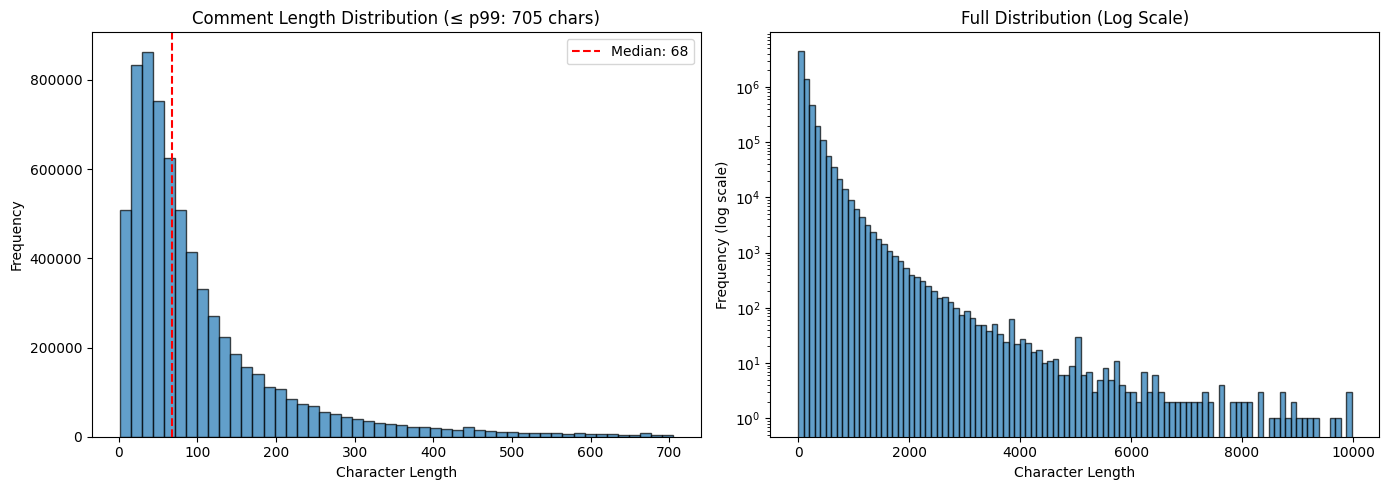

In [13]:
# body length histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Full distribution (capped at 99th percentile for visibility)
p99 = df_with_length["body_length"].quantile(0.99)
axes[0].hist(
    df_with_length.filter(pl.col("body_length") <= p99)["body_length"].to_numpy(),
    bins=50,
    edgecolor="black",
    alpha=0.7,
)
axes[0].set_xlabel("Character Length")
axes[0].set_ylabel("Frequency")
axes[0].set_title(f"Comment Length Distribution (≤ p99: {p99:.0f} chars)")
axes[0].axvline(
    df_with_length["body_length"].median(),
    color="red",
    linestyle="--",
    label=f"Median: {df_with_length['body_length'].median():.0f}",
)
axes[0].legend()

# Right plot: Log scale to see the tail
axes[1].hist(
    df_with_length["body_length"].to_numpy(), bins=100, edgecolor="black", alpha=0.7
)
axes[1].set_xlabel("Character Length")
axes[1].set_ylabel("Frequency (log scale)")
axes[1].set_title("Full Distribution (Log Scale)")
axes[1].set_yscale("log")

plt.tight_layout()
plt.show()

### 1.4 Token & Cost Estimation

In [ ]:
print("=" * 60)
print("TOKEN & COST ESTIMATION")
print("=" * 60)

# Token estimation: ~4 characters per token (conservative estimate)
CHARS_PER_TOKEN = 4
HAIKU_INPUT_COST = 0.50  # per million tokens (batch)
HAIKU_OUTPUT_COST = 2.50  # per million tokens (batch)
SYSTEM_PROMPT_TOKENS = 150  # estimated overhead per request
OUTPUT_TOKENS_PER_COMMENT = 10  # short classification response

total_chars = df_with_length["body_length"].sum()
total_tokens = total_chars / CHARS_PER_TOKEN
avg_tokens_per_comment = total_tokens / len(df)

print(f"Total characters: {total_chars:,.0f}")
print(f"Estimated total tokens (body only): {total_tokens:,.0f}")
print(f"Average tokens per comment: {avg_tokens_per_comment:.1f}")

# Cost scenarios
scenarios = [
    ("All comments (6.89M)", len(df)),
    ("50% filter (3.45M)", len(df) * 0.5),
    ("30% filter (2.07M)", len(df) * 0.3),
    ("20% filter (1.38M)", len(df) * 0.2),
]

print(f"\n{'Scenario':<25} {'Input $':>10} {'Output $':>10} {'Total $':>10}")
print("-" * 58)

for name, count in scenarios:
    input_tokens = count * (avg_tokens_per_comment + SYSTEM_PROMPT_TOKENS)
    output_tokens = count * OUTPUT_TOKENS_PER_COMMENT
    input_cost = (input_tokens / 1_000_000) * HAIKU_INPUT_COST
    output_cost = (output_tokens / 1_000_000) * HAIKU_OUTPUT_COST
    total_cost = input_cost + output_cost
    print(f"{name:<25} ${input_cost:>9.2f} ${output_cost:>9.2f} ${total_cost:>9.2f}")

TOKEN & COST ESTIMATION
Total characters: 773,567,344
Estimated total tokens (body only): 193,391,836
Average tokens per comment: 28.1

Scenario                     Input $   Output $    Total $
----------------------------------------------------------
All comments (6.89M)      $   490.83 $   137.82 $   628.65
50% filter (3.45M)        $   245.41 $    68.91 $   314.32
30% filter (2.07M)        $   147.25 $    41.35 $   188.59
20% filter (1.38M)        $    98.17 $    27.56 $   125.73


## 2.0 Temporal Analysis
### 2.1 Setup

In [ ]:
print("=" * 60)
print("TEMPORAL ANALYSIS")
print("=" * 60)

# Convert unix timestamp to datetime
df_temporal = df.with_columns(pl.from_epoch("created_utc").alias("created_at"))

# Extract date components
df_temporal = df_temporal.with_columns(
    [
        pl.col("created_at").dt.date().alias("date"),
        pl.col("created_at").dt.year().alias("year"),
        pl.col("created_at").dt.month().alias("month"),
        pl.col("created_at").dt.weekday().alias("weekday"),  # 1=Monday, 7=Sunday
    ]
)

# Date range
print(f"\nDate range: {df_temporal['date'].min()} to {df_temporal['date'].max()}")
print(f"Total days: {(df_temporal['date'].max() - df_temporal['date'].min()).days}")

TEMPORAL ANALYSIS

Date range: 2024-10-01 to 2025-06-30
Total days: 272


### 2.2 Daily Volume & Gap Detection

In [ ]:
daily_counts = df_temporal.group_by("date").agg(pl.len().alias("count")).sort("date")

print("\nDaily volume statistics:")
print(daily_counts.select("count").describe())

# Check for gaps (days with 0 comments) - sanity check
all_dates = set(daily_counts["date"].to_list())
min_date = df_temporal["date"].min()
max_date = df_temporal["date"].max()

expected_dates = set()
current = min_date
while current <= max_date:
    expected_dates.add(current)
    current += timedelta(days=1)

missing_dates = expected_dates - all_dates
print(f"\nMissing dates (gaps): {len(missing_dates)}")
if missing_dates:
    print(f"Missing: {sorted(missing_dates)[:10]}...")


Daily volume statistics:
shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ count        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 273.0        │
│ null_count ┆ 0.0          │
│ mean       ┆ 25242.355311 │
│ std        ┆ 15762.829769 │
│ min        ┆ 4587.0       │
│ 25%        ┆ 14924.0      │
│ 50%        ┆ 19803.0      │
│ 75%        ┆ 30127.0      │
│ max        ┆ 107852.0     │
└────────────┴──────────────┘

Missing dates (gaps): 0


### 2.4 Monthly Volume

In [20]:
monthly_counts = (
    df_temporal.group_by(["year", "month"])
    .agg(pl.len().alias("count"))
    .sort(["year", "month"])
)

print("\nMonthly comment volume:")
print(monthly_counts)


Monthly comment volume:
shape: (9, 3)
┌──────┬───────┬─────────┐
│ year ┆ month ┆ count   │
│ ---  ┆ ---   ┆ ---     │
│ i32  ┆ i8    ┆ u32     │
╞══════╪═══════╪═════════╡
│ 2024 ┆ 10    ┆ 438028  │
│ 2024 ┆ 11    ┆ 519265  │
│ 2024 ┆ 12    ┆ 474261  │
│ 2025 ┆ 1     ┆ 549684  │
│ 2025 ┆ 2     ┆ 917615  │
│ 2025 ┆ 3     ┆ 658826  │
│ 2025 ┆ 4     ┆ 1043743 │
│ 2025 ┆ 5     ┆ 1409100 │
│ 2025 ┆ 6     ┆ 880641  │
└──────┴───────┴─────────┘


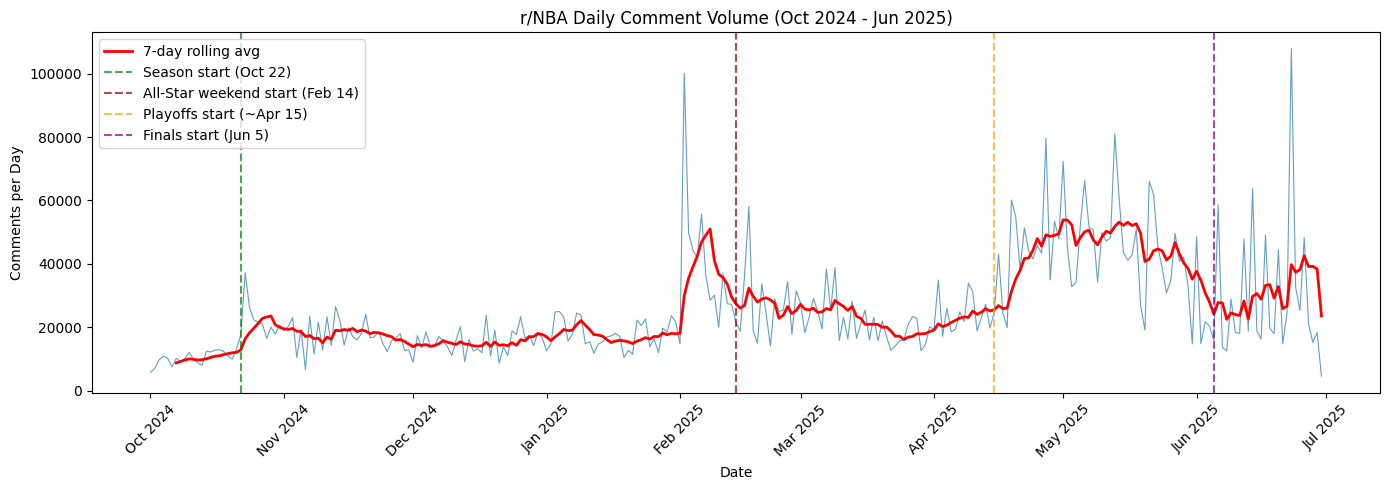

In [31]:
daily_df = daily_counts.to_pandas()
daily_df["date"] = pd.to_datetime(daily_df["date"])

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(daily_df["date"], daily_df["count"], linewidth=0.8, alpha=0.7)

# Add monthly average as smoothed line
daily_df["rolling_7d"] = daily_df["count"].rolling(7).mean()
ax.plot(
    daily_df["date"],
    daily_df["rolling_7d"],
    color="red",
    linewidth=2,
    label="7-day rolling avg",
)

# Key dates
ax.axvline(
    pd.Timestamp("2024-10-22"),
    color="green",
    linestyle="--",
    alpha=0.7,
    label="Season start (Oct 22)",
)
ax.axvline(
    pd.Timestamp("2025-02-14"),
    color="darkred",
    linestyle="--",
    alpha=0.7,
    label="All-Star weekend start (Feb 14)",
)
ax.axvline(
    pd.Timestamp("2025-04-15"),
    color="orange",
    linestyle="--",
    alpha=0.7,
    label="Playoffs start (~Apr 15)",
)
ax.axvline(
    pd.Timestamp("2025-06-05"),
    color="purple",
    linestyle="--",
    alpha=0.7,
    label="Finals start (Jun 5)",
)

ax.set_xlabel("Date")
ax.set_ylabel("Comments per Day")
ax.set_title("r/NBA Daily Comment Volume (Oct 2024 - Jun 2025)")
ax.legend(loc="upper left")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('outputs/daily_volume_timeseries.png', dpi=150)
plt.show()

### 2.5 Daily Volume

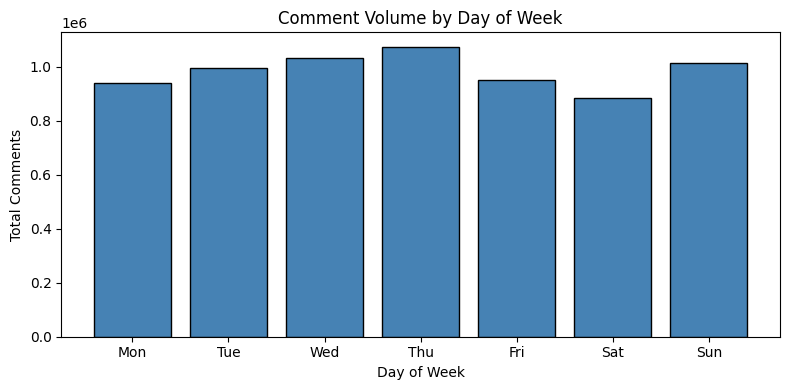

In [39]:
dow_counts = (
    df_temporal.group_by("weekday").agg(pl.len().alias("count")).sort("weekday")
)

dow_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dow_df = dow_counts.to_pandas()
dow_df["day_name"] = dow_df["weekday"].map(lambda x: dow_names[x - 1])

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(dow_df["day_name"], dow_df["count"], color="steelblue", edgecolor="black")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Total Comments")
ax.set_title("Comment Volume by Day of Week")
plt.tight_layout()
plt.show()

## 3.0 Flair Analysis
### 3.1 Flair Coverage Summary

In [40]:
print("=" * 60)
print("FLAIR ANALYSIS")
print("=" * 60)

total = len(df)
has_flair = df.filter(pl.col("author_flair_text").is_not_null()).height
no_flair = total - has_flair

print("\nFlair coverage:")
print(f"  With flair:    {has_flair:>10,} ({has_flair / total * 100:.1f}%)")
print(f"  Without flair: {no_flair:>10,} ({no_flair / total * 100:.1f}%)")

FLAIR ANALYSIS

Flair coverage:
  With flair:     4,481,969 (65.0%)
  Without flair:  2,409,194 (35.0%)


In [42]:
print("\nTop 50 author_flair_text values:")
flair_counts = (
    df.filter(pl.col("author_flair_text").is_not_null())
    .group_by("author_flair_text")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)

print(f"Unique flair values: {flair_counts.height:,}")
print(flair_counts.head(50))


Top 50 author_flair_text values:
Unique flair values: 2,225
shape: (50, 2)
┌────────────────────────────────┬────────┐
│ author_flair_text              ┆ count  │
│ ---                            ┆ ---    │
│ str                            ┆ u32    │
╞════════════════════════════════╪════════╡
│ :lal-1: Lakers                 ┆ 194473 │
│ :lal-2: Lakers                 ┆ 138555 │
│ :min-1: Timberwolves           ┆ 119192 │
│ :okc-1: Thunder                ┆ 106373 │
│ :gsw-1: Warriors               ┆ 104295 │
│ :bos-1: Celtics                ┆ 100514 │
│ :nyk-1: Knicks                 ┆ 95914  │
│ :nba-1: NBA                    ┆ 88953  │
│ Lakers                         ┆ 79969  │
│ :bos-3: Celtics                ┆ 76622  │
│ Celtics                        ┆ 68646  │
│ :okc-2: Thunder                ┆ 66937  │
│ :den-1: Nuggets                ┆ 66650  │
│ :tor-4: Raptors                ┆ 66027  │
│ :okc-3: Thunder                ┆ 56394  │
│ …                              ┆ …      │


In [43]:
print("\nTop 50 author_flair_css_class values:")
css_counts = (
    df.filter(pl.col("author_flair_css_class").is_not_null())
    .group_by("author_flair_css_class")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)

print(f"Unique CSS class values: {css_counts.height:,}")
print(css_counts.head(50))


Top 50 author_flair_css_class values:
Unique CSS class values: 322
shape: (50, 2)
┌────────────────────────┬────────┐
│ author_flair_css_class ┆ count  │
│ ---                    ┆ ---    │
│ str                    ┆ u32    │
╞════════════════════════╪════════╡
│ Lakers1                ┆ 262758 │
│ Lakers2                ┆ 165763 │
│ Warriors1              ┆ 139147 │
│ Celtics1               ┆ 138942 │
│ Thunder1               ┆ 137605 │
│ Knicks1                ┆ 119880 │
│ NBA                    ┆ 118403 │
│ Celtics3               ┆ 97019  │
│ Timberwolves1          ┆ 95018  │
│ Thunder2               ┆ 92006  │
│ Raptors4               ┆ 81135  │
│ Nuggets1               ┆ 75921  │
│ Bulls1                 ┆ 70418  │
│ Mavs2                  ┆ 64172  │
│ Thunder3               ┆ 61891  │
│ …                      ┆ …      │
│ Suns2                  ┆ 34882  │
│ Timberwolves3          ┆ 34770  │
│ Nuggets4               ┆ 34745  │
│ Rockets2               ┆ 34687  │
│ Cavaliers1     

In [48]:
# Define expected team identifiers (lowercase for matching)
NBA_TEAMS = {
    # Team name variations we might see in flairs
    "lakers": "LAL",
    "los angeles lakers": "LAL",
    "celtics": "BOS",
    "boston celtics": "BOS",
    "warriors": "GSW",
    "golden state warriors": "GSW",
    "golden state": "GSW",
    "bulls": "CHI",
    "chicago bulls": "CHI",
    "heat": "MIA",
    "miami heat": "MIA",
    "knicks": "NYK",
    "new york knicks": "NYK",
    "nets": "BKN",
    "brooklyn nets": "BKN",
    "sixers": "PHI",
    "76ers": "PHI",
    "philadelphia 76ers": "PHI",
    "raptors": "TOR",
    "toronto raptors": "TOR",
    "cavaliers": "CLE",
    "cavs": "CLE",
    "cleveland cavaliers": "CLE",
    "pistons": "DET",
    "detroit pistons": "DET",
    "pacers": "IND",
    "indiana pacers": "IND",
    "bucks": "MIL",
    "milwaukee bucks": "MIL",
    "hawks": "ATL",
    "atlanta hawks": "ATL",
    "hornets": "CHA",
    "charlotte hornets": "CHA",
    "magic": "ORL",
    "orlando magic": "ORL",
    "wizards": "WAS",
    "washington wizards": "WAS",
    "nuggets": "DEN",
    "denver nuggets": "DEN",
    "timberwolves": "MIN",
    "wolves": "MIN",
    "minnesota timberwolves": "MIN",
    "thunder": "OKC",
    "oklahoma city thunder": "OKC",
    "trail blazers": "POR",
    "blazers": "POR",
    "portland trail blazers": "POR",
    "jazz": "UTA",
    "utah jazz": "UTA",
    "clippers": "LAC",
    "los angeles clippers": "LAC",
    "la clippers": "LAC",
    "suns": "PHX",
    "phoenix suns": "PHX",
    "kings": "SAC",
    "sacramento kings": "SAC",
    "mavericks": "DAL",
    "mavs": "DAL",
    "dallas mavericks": "DAL",
    "rockets": "HOU",
    "houston rockets": "HOU",
    "grizzlies": "MEM",
    "memphis grizzlies": "MEM",
    "pelicans": "NOP",
    "new orleans pelicans": "NOP",
    "spurs": "SAS",
    "san antonio spurs": "SAS",
}

# Check how many of the top flairs match known teams
top_flairs = flair_counts.head(100)["author_flair_text"].to_list()
matched = []
unmatched = []

for flair in top_flairs:
    flair_lower = flair.lower().strip()
    if flair_lower in NBA_TEAMS:
        matched.append((flair, NBA_TEAMS[flair_lower]))
    else:
        # Check if any team name is contained in the flair
        found = False
        for team_key, team_code in NBA_TEAMS.items():
            if team_key in flair_lower:
                matched.append((flair, team_code))
                found = True
                break
        if not found:
            unmatched.append(flair)

print("\nTop 100 flairs - team mapping results:")
print(f"  Matched to NBA team: {len(matched)}")
print(f"  Unmatched: {len(unmatched)}")

print("\nSample matched flairs:")
for flair, team in matched[:15]:
    print(f"  '{flair}' -> {team}")

print("\nUnmatched flairs (first 20):")
for flair in unmatched[:20]:
    print(f"  '{flair}'")


Top 100 flairs - team mapping results:
  Matched to NBA team: 94
  Unmatched: 6

Sample matched flairs:
  ':lal-1: Lakers' -> LAL
  ':lal-2: Lakers' -> LAL
  ':min-1: Timberwolves' -> MIN
  ':okc-1: Thunder' -> OKC
  ':gsw-1: Warriors' -> GSW
  ':bos-1: Celtics' -> BOS
  ':nyk-1: Knicks' -> NYK
  'Lakers' -> LAL
  ':bos-3: Celtics' -> BOS
  'Celtics' -> BOS
  ':okc-2: Thunder' -> OKC
  ':den-1: Nuggets' -> DEN
  ':tor-4: Raptors' -> TOR
  ':okc-3: Thunder' -> OKC
  'Thunder' -> OKC

Unmatched flairs (first 20):
  ':nba-1: NBA'
  ':sea-3: Supersonics'
  ':USA: United States'
  ':SLV: Slovenia'
  'NBA'
  ':wc-1: West'


## 4.0 Context Problem
Need to answer:
1. What % of comments explicitly mention a player name?
2. How are comments distributed across posts?
3. Are non-mention comments actually useful, or mostly noise?

### 4.1 Player Mention Setup

In [50]:
print("=" * 60)
print("PLAYER MENTION ANALYSIS")
print("=" * 60)

# Top 50 active players + common nicknames (2024-25 season)
# This isn't exhaustive - just enough to estimate mention rate
PLAYER_PATTERNS = {
    "LeBron James": ["lebron", "bron", "lbj", "legoat", "king james"],
    "Stephen Curry": ["curry", "steph"],
    "Kevin Durant": ["durant", "kd"],
    "Giannis Antetokounmpo": ["giannis", "antetokounmpo", "greek freak"],
    "Luka Doncic": ["luka", "doncic"],
    "Nikola Jokic": ["jokic", "joker"],
    "Joel Embiid": ["embiid"],
    "Jayson Tatum": ["tatum"],
    "Jaylen Brown": ["jaylen brown", "jaylen"],
    "Jimmy Butler": ["jimmy butler", "jimmy", "butler", "jimmy buckets"],
    "Anthony Edwards": ["anthony edwards", "ant", "edwards"],
    "Shai Gilgeous-Alexander": ["shai", "sga", "gilgeous"],
    "Donovan Mitchell": ["donovan mitchell", "spida"],
    "Devin Booker": ["booker", "book"],
    "Kyrie Irving": ["kyrie"],
    "James Harden": ["harden"],
    "Paul George": ["paul george", "pg13"],
    "Kawhi Leonard": ["kawhi", "leonard", "klaw"],
    "Anthony Davis": ["anthony davis", "ad"],
    "Damian Lillard": ["lillard", "dame"],
    "Ja Morant": ["ja morant", "ja"],
    "Zion Williamson": ["zion"],
    "Trae Young": ["trae"],
    "Draymond Green": ["draymond"],
    "Russell Westbrook": ["westbrook", "russ", "westbrick"],
    "Chris Paul": ["chris paul", "cp3"],
    "Victor Wembanyama": ["wembanyama", "wemby", "victor"],
    "Chet Holmgren": ["chet", "holmgren"],
    "Paolo Banchero": ["paolo", "banchero"],
    "Tyrese Haliburton": ["haliburton"],
    "Tyrese Maxey": ["maxey"],
    "De'Aaron Fox": ["fox", "de'aaron"],
    "LaMelo Ball": ["lamelo", "melo ball"],
    "Lonzo Ball": ["lonzo"],
    "Scottie Barnes": ["scottie barnes", "scottie"],
    "Karl-Anthony Towns": ["kat", "towns"],
    "Rudy Gobert": ["gobert", "rudy"],
    "Bam Adebayo": ["bam", "adebayo"],
    "Jaren Jackson Jr": ["jaren jackson", "jjj"],
    "Desmond Bane": ["bane"],
    "Jalen Brunson": ["brunson"],
    "Julius Randle": ["randle"],
    "Brandon Ingram": ["ingram"],
    "DeMar DeRozan": ["demar", "derozan"],
    "Zach LaVine": ["lavine", "zach lavine"],
    "Pascal Siakam": ["siakam", "pascal", "spicy p", "spinakam"],
    "OG Anunoby": ["og", "anunoby"],
    "Mikal Bridges": ["mikal bridges", "mikal"],
    "Alperen Sengun": ["sengun", "alperen"],
    "Cade Cunningham": ["cade", "cunningham"],
}

# Flatten to list of patterns for regex
all_patterns = []
for player, aliases in PLAYER_PATTERNS.items():
    all_patterns.extend(aliases)

# Build regex (word boundaries to avoid false positives)
pattern = r"\b(" + "|".join(re.escape(p) for p in all_patterns) + r")\b"
player_regex = re.compile(pattern, re.IGNORECASE)

print(f"Tracking {len(PLAYER_PATTERNS)} players with {len(all_patterns)} name patterns")

PLAYER MENTION ANALYSIS
Tracking 50 players with 99 name patterns


In [51]:
# Sample for speed - 100K should give us a reliable estimate
SAMPLE_SIZE = 100_000

df_sample = df.sample(n=SAMPLE_SIZE, seed=42)


# Check for player mentions
def has_player_mention(body: str) -> bool:
    return bool(player_regex.search(body))


# Apply to sample
mention_results = df_sample.with_columns(
    pl.col("body")
    .map_elements(has_player_mention, return_dtype=pl.Boolean)
    .alias("has_mention")
)

mention_rate = mention_results["has_mention"].mean()
mention_count = mention_results["has_mention"].sum()

print(f"\nPlayer mention analysis (n={SAMPLE_SIZE:,}):")
print(f"  Comments with player mention: {mention_count:,} ({mention_rate * 100:.1f}%)")
print(
    f"  Comments without mention:     {SAMPLE_SIZE - mention_count:,} ({(1 - mention_rate) * 100:.1f}%)"
)

print("\nProjected full dataset:")
print(f"  With mention:    {int(len(df) * mention_rate):,}")
print(f"  Without mention: {int(len(df) * (1 - mention_rate)):,}")


Player mention analysis (n=100,000):
  Comments with player mention: 22,437 (22.4%)
  Comments without mention:     77,563 (77.6%)

Projected full dataset:
  With mention:    1,546,170
  Without mention: 5,344,992


### 4.2 Comments Per Post Distribution

In [52]:
print("\n" + "=" * 60)
print("COMMENTS PER POST DISTRIBUTION")
print("=" * 60)

# Count comments per link_id (post)
comments_per_post = (
    df.group_by("link_id")
    .agg(pl.len().alias("comment_count"))
    .sort("comment_count", descending=True)
)

print(f"\nTotal unique posts: {comments_per_post.height:,}")
print("\nComments per post statistics:")
print(comments_per_post.select("comment_count").describe())

# Percentiles
cpp_percentiles = comments_per_post.select(
    pl.col("comment_count").quantile(0.50).alias("p50"),
    pl.col("comment_count").quantile(0.75).alias("p75"),
    pl.col("comment_count").quantile(0.90).alias("p90"),
    pl.col("comment_count").quantile(0.95).alias("p95"),
    pl.col("comment_count").quantile(0.99).alias("p99"),
)
print("\nPercentiles:")
print(cpp_percentiles)

print("\nTop 10 posts by comment count:")
print(comments_per_post.head(10))


COMMENTS PER POST DISTRIBUTION

Total unique posts: 75,776

Comments per post statistics:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ comment_count │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 75776.0       │
│ null_count ┆ 0.0           │
│ mean       ┆ 90.941235     │
│ std        ┆ 541.062231    │
│ min        ┆ 1.0           │
│ 25%        ┆ 1.0           │
│ 50%        ┆ 15.0          │
│ 75%        ┆ 58.0          │
│ max        ┆ 41684.0       │
└────────────┴───────────────┘

Percentiles:
shape: (1, 5)
┌──────┬──────┬───────┬───────┬────────┐
│ p50  ┆ p75  ┆ p90   ┆ p95   ┆ p99    │
│ ---  ┆ ---  ┆ ---   ┆ ---   ┆ ---    │
│ f64  ┆ f64  ┆ f64   ┆ f64   ┆ f64    │
╞══════╪══════╪═══════╪═══════╪════════╡
│ 15.0 ┆ 58.0 ┆ 173.0 ┆ 353.0 ┆ 1038.0 │
└──────┴──────┴───────┴───────┴────────┘

Top 10 posts by comment count:
shape: (10, 2)
┌────────────┬───────────────┐
│ link_id    ┆ comment_count │
│ --- 

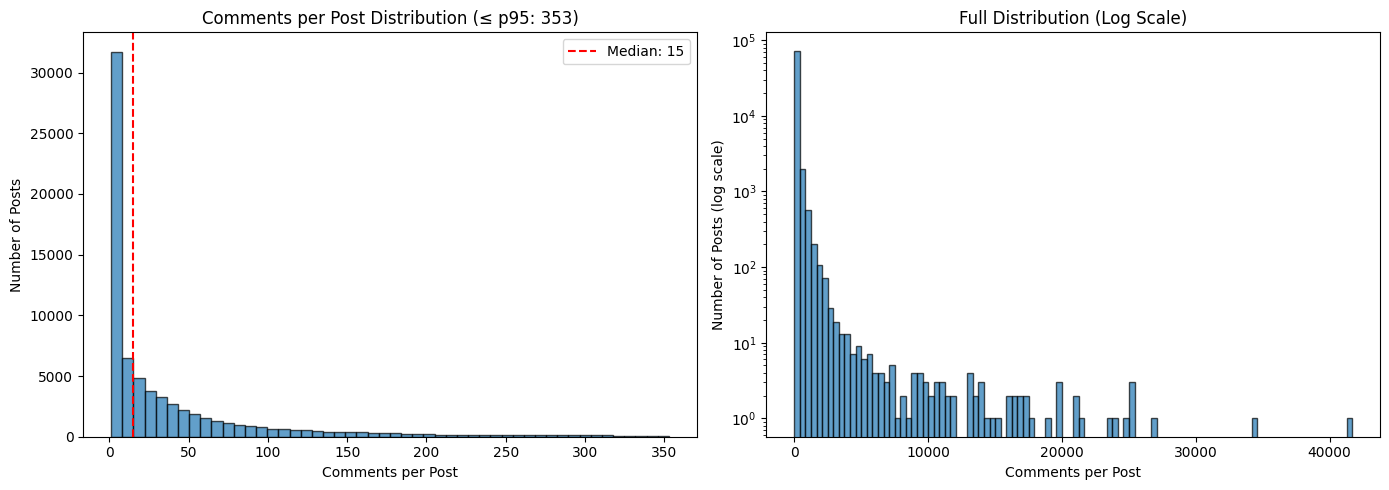

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cpp_data = comments_per_post["comment_count"].to_numpy()

# Left: Distribution up to p95 (readable)
p95 = int(comments_per_post["comment_count"].quantile(0.95))
axes[0].hist(cpp_data[cpp_data <= p95], bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Comments per Post")
axes[0].set_ylabel("Number of Posts")
axes[0].set_title(f"Comments per Post Distribution (≤ p95: {p95})")
axes[0].axvline(
    comments_per_post["comment_count"].median(),
    color="red",
    linestyle="--",
    label=f"Median: {comments_per_post['comment_count'].median():.0f}",
)
axes[0].legend()

# Right: Log scale for full distribution
axes[1].hist(cpp_data, bins=100, edgecolor="black", alpha=0.7)
axes[1].set_xlabel("Comments per Post")
axes[1].set_ylabel("Number of Posts (log scale)")
axes[1].set_title("Full Distribution (Log Scale)")
axes[1].set_yscale("log")

plt.tight_layout()
plt.show()

### 4.3 Non-Mention Comments

In [54]:
print("\n" + "=" * 60)
print("SAMPLE NON-MENTION COMMENTS (Manual Review)")
print("=" * 60)

# Get comments WITHOUT player mentions
no_mention = mention_results.filter(~pl.col("has_mention"))

# Sample 30 for manual review, varying body lengths
short = no_mention.filter(pl.col("body").str.len_chars() < 50).sample(n=10, seed=1)
medium = no_mention.filter(
    (pl.col("body").str.len_chars() >= 50) & (pl.col("body").str.len_chars() < 150)
).sample(n=10, seed=2)
long = no_mention.filter(pl.col("body").str.len_chars() >= 150).sample(n=10, seed=3)

print("\n--- SHORT (<50 chars) ---")
for row in short.iter_rows(named=True):
    print(f"  [{row['score']:>4}] {row['body'][:100]}")

print("\n--- MEDIUM (50-150 chars) ---")
for row in medium.iter_rows(named=True):
    print(f"  [{row['score']:>4}] {row['body'][:150]}")

print("\n--- LONG (150+ chars) ---")
for row in long.iter_rows(named=True):
    print(f"  [{row['score']:>4}] {row['body'][:200]}...")


SAMPLE NON-MENTION COMMENTS (Manual Review)

--- SHORT (<50 chars) ---
  [   4] Send da final score
  [  11] He was ass last game too…
  [   1] Not everyone… \*cough\* Jordan Poole \*cough\*
  [   1] Alternative options?
  [   6] Lol
  [   2] Sounds like he's an idiot
  [   1] Dort’s first road 3 since March 25th
  [   6] Best player in NBA history
  [   2] GG
  [   3] Wow Castle was very clearly fouled on that drive

--- MEDIUM (50-150 chars) ---
  [  10] They really had Griffey sr and jr courtside for a few passes and clanked jump shots lol
  [   1] Well, no. It wasn't magic. It was luck, which is seemingly not understood by this sub
  [  34] The only chip in NBA history that doesn’t have an asterisk is 1977. Everyone else is a fraud. MJ is a goodatbasketball merchant
  [ 590] What Nico meant was “we didn’t want to pay him the supermax”.
  [  -2] He did but the refs are cheating. Only had possession when the Magic gave up  after the whistle.
  [   1] They would have to schedule the 

### 4.4 Short Comment Analysis

In [55]:
print("=" * 60)
print("SHORT COMMENT NOISE ANALYSIS")
print("=" * 60)

df_with_length = df.with_columns(pl.col("body").str.len_chars().alias("body_length"))

# Distribution by length buckets
length_buckets = df_with_length.with_columns(
    pl.when(pl.col("body_length") < 20)
    .then(pl.lit("< 20 chars"))
    .when(pl.col("body_length") < 50)
    .then(pl.lit("20-49 chars"))
    .when(pl.col("body_length") < 100)
    .then(pl.lit("50-99 chars"))
    .when(pl.col("body_length") < 200)
    .then(pl.lit("100-199 chars"))
    .otherwise(pl.lit("200+ chars"))
    .alias("length_bucket")
)

bucket_counts = (
    length_buckets.group_by("length_bucket")
    .agg(pl.len().alias("count"))
    .with_columns((pl.col("count") / len(df) * 100).alias("pct"))
    .sort("count", descending=True)
)

print("\nComment distribution by length:")
print(bucket_counts)

# Sample ultra-short comments
print("\n--- Sample comments < 20 chars ---")
ultra_short = df.filter(pl.col("body").str.len_chars() < 20).sample(n=20, seed=42)
for row in ultra_short.iter_rows(named=True):
    print(f"  [{row['score']:>4}] '{row['body']}'")

SHORT COMMENT NOISE ANALYSIS

Comment distribution by length:
shape: (5, 3)
┌───────────────┬─────────┬───────────┐
│ length_bucket ┆ count   ┆ pct       │
│ ---           ┆ ---     ┆ ---       │
│ str           ┆ u32     ┆ f64       │
╞═══════════════╪═════════╪═══════════╡
│ 50-99 chars   ┆ 1960014 ┆ 28.442427 │
│ 20-49 chars   ┆ 1815107 ┆ 26.339632 │
│ 100-199 chars ┆ 1426465 ┆ 20.699917 │
│ 200+ chars    ┆ 961592  ┆ 13.953987 │
│ < 20 chars    ┆ 727985  ┆ 10.564037 │
└───────────────┴─────────┴───────────┘

--- Sample comments < 20 chars ---
  [  89] 'Or Indiana'
  [   6] 'AD legacy game tbh'
  [   1] 'Yes it is.'
  [   1] 'big balls indeed!'
  [   1] 'Not SGA for sure.'
  [  45] 'Why must we suffer.'
  [   0] 'ignorant'
  [   3] 'Luka is fat'
  [   2] 'Danny Schayes'
  [   1] 'So skilled 🤓'
  [   1] 'Yeah you are'
  [   2] 'HALI BOMB'
  [   2] 'Beat and tilted'
  [   1] 'Huh'
  [   1] 'M-V-He, M-V-He!'
  [   0] 'Weird music choice'
  [   1] 'I respect the grind'
  [   2] 'Absolute

In [56]:
print("\n" + "=" * 60)
print("FILTERING STRATEGY COMPARISON")
print("=" * 60)

# Constants
CHARS_PER_TOKEN = 4
SYSTEM_PROMPT_TOKENS = 150
POST_TITLE_TOKENS = 30  # Average post title
OUTPUT_TOKENS = 10
HAIKU_INPUT_COST = 0.50 / 1_000_000
HAIKU_OUTPUT_COST = 2.50 / 1_000_000

total_comments = len(df)
avg_comment_tokens = df_with_length["body_length"].mean() / CHARS_PER_TOKEN

# Scenario calculations
scenarios = {
    "All comments (no filter)": {
        "count": total_comments,
        "input_tokens": SYSTEM_PROMPT_TOKENS + avg_comment_tokens,
    },
    "With post titles (no filter)": {
        "count": total_comments,
        "input_tokens": SYSTEM_PROMPT_TOKENS + POST_TITLE_TOKENS + avg_comment_tokens,
    },
    "Player mention only (22.4%)": {
        "count": int(total_comments * 0.224),
        "input_tokens": SYSTEM_PROMPT_TOKENS + avg_comment_tokens,
    },
    "Post titles + min 20 chars": {
        "count": int(total_comments * 0.85),  # Estimate ~15% under 20 chars
        "input_tokens": SYSTEM_PROMPT_TOKENS + POST_TITLE_TOKENS + avg_comment_tokens,
    },
    "Post titles + min 50 chars": {
        "count": int(total_comments * 0.70),  # Estimate ~30% under 50 chars
        "input_tokens": SYSTEM_PROMPT_TOKENS + POST_TITLE_TOKENS + avg_comment_tokens,
    },
    "Player mention OR post mentions player": {
        "count": int(total_comments * 0.50),  # Conservative estimate
        "input_tokens": SYSTEM_PROMPT_TOKENS + POST_TITLE_TOKENS + avg_comment_tokens,
    },
}

print(
    f"{'Strategy':<45} {'Comments':>12} {'Input $':>10} {'Output $':>10} {'Total $':>10}"
)
print("-" * 90)

for name, params in scenarios.items():
    count = params["count"]
    input_tokens = count * params["input_tokens"]
    output_tokens = count * OUTPUT_TOKENS
    input_cost = input_tokens * HAIKU_INPUT_COST
    output_cost = output_tokens * HAIKU_OUTPUT_COST
    total = input_cost + output_cost
    print(
        f"{name:<45} {count:>12,} ${input_cost:>9.2f} ${output_cost:>9.2f} ${total:>9.2f}"
    )

print("\n" + "=" * 60)
print("BUDGET: $200")
print("=" * 60)


FILTERING STRATEGY COMPARISON
Strategy                                          Comments    Input $   Output $    Total $
------------------------------------------------------------------------------------------
All comments (no filter)                         6,891,163 $   613.53 $   172.28 $   785.81
With post titles (no filter)                     6,891,163 $   716.90 $   172.28 $   889.18
Player mention only (22.4%)                      1,543,620 $   137.43 $    38.59 $   176.02
Post titles + min 20 chars                       5,857,488 $   609.37 $   146.44 $   755.80
Post titles + min 50 chars                       4,823,814 $   501.83 $   120.60 $   622.43
Player mention OR post mentions player           3,445,581 $   358.45 $    86.14 $   444.59

BUDGET: $200


In [59]:
print("\n" + "=" * 60)
print("EDA SUMMARY - KEY METRICS")
print("=" * 60)

summary = {
    "Total comments": f"{len(df):,}",
    "Date range": f"{df_temporal['date'].min()} to {df_temporal['date'].max()}",
    "Flair coverage": f"{(1 - df['author_flair_text'].null_count() / len(df)) * 100:.1f}%",
    "Unique teams in flairs": "30 NBA teams + extras (Sonics, NBA, countries)",
    "Median comment length": f"{df_with_length['body_length'].median():.0f} chars (~{df_with_length['body_length'].median() / 4:.0f} tokens)",
    "Player mention rate": "22.4%",
    "Unique posts": f"{comments_per_post.height:,}",
    "Median comments/post": f"{comments_per_post['comment_count'].median():.0f}",
}

for key, value in summary.items():
    print(f"  {key:<30} {value}")


EDA SUMMARY - KEY METRICS
  Total comments                 6,891,163
  Date range                     2024-10-01 to 2025-06-30
  Flair coverage                 65.0%
  Unique teams in flairs         30 NBA teams + extras (Sonics, NBA, countries)
  Median comment length          68 chars (~17 tokens)
  Player mention rate            22.4%
  Unique posts                   75,776
  Median comments/post           15


---

## 5.0 Summary Report

## Dataset Overview

| Metric | Value |
|--------|-------|
| Total comments | 6,891,163 |
| Date range | Oct 1, 2024 – Jun 30, 2025 (272 days) |
| Unique posts | 75,776 |
| Data gaps | None |

## Key Findings

### 1. Data Quality: ✅ Excellent
- Zero nulls on critical fields (body, link_id, created_utc)
- 97.87% acceptance rate from raw data
- Complete temporal coverage with no missing days

### 2. Flair Coverage: ✅ Sufficient for Team Segmentation
- **65%** of comments have author flair
- 92 of top 100 flairs map cleanly to NBA teams
- Simple regex normalization required (`:lal-1: Lakers` → `Lakers`)

### 3. Temporal Patterns: ✅ Expected Distribution
- Playoff spike confirmed: May 2025 volume (1.41M) is **2.3x** regular season average
- Peak single day: 107,852 comments
- Day-of-week variation is minimal (~20%)

### 4. Comment Length: ⚠️ Shorter Than Expected
- Median: 68 characters (~17 tokens)
- 10.5% of comments are <20 characters
- Short comments still carry sentiment signal ("Luka is fat")

### 5. Context Problem: 🚨 Critical Finding
- **Only 22.4%** of comments explicitly mention a player name
- 77.6% of sentiment requires post context to attribute
- Median 15 comments per post — context propagation is viable

## Budget Analysis

| Strategy | Comments | Cost | Coverage |
|----------|----------|------|----------|
| Player mention only | 1.54M | $176 | 22% of sentiment |
| Post titles + filters | TBD | TBD | TBD |
| All comments | 6.89M | $786 | 100% |

**Current budget: $200-300**

## Recommendations

### Immediate Next Steps
1. **Download posts from Arctic Shift** — 75K posts is a small download
2. **Analyze post titles** — What % mention players? What % are game threads?
3. **Revisit filtering strategy** with post data in hand

### Filtering Strategy (Preliminary)
- Include post title in prompt for context attribution
- Filter OUT game threads (high volume, low signal)
- Filter TO posts where title mentions a tracked player
- Minimum comment length: 20 chars (tentative — may drop)

### Open Questions for Phase 2
1. What % of posts mention a player in the title?
2. What's the game thread vs. discussion post split?
3. Can we achieve $200-300 cost with adequate coverage?

---

*Report generated: December 29, 2024*
*Data source: r/NBA comments, Oct 2024 – Jun 2025*